# Deep Neural Network for Image Classification: Application

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

In [27]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data(600)
print("train_x_orig: ", train_x_orig)
print("train_y: ", train_y)
print("test_x_orig: ", test_x_orig)
print("test_y: ", test_y)
print("classes: ", classes)


train_x_orig:  [[[[ 99  99  99]
   [151 151 151]
   [168 168 168]
   ...
   [ 62  62  62]
   [ 31  31  31]
   [ 22  22  22]]

  [[119 119 119]
   [149 149 149]
   [154 154 154]
   ...
   [ 50  50  50]
   [ 16  16  16]
   [  5   5   5]]

  [[131 131 131]
   [148 148 148]
   [150 150 150]
   ...
   [ 42  42  42]
   [  6   6   6]
   [  0   0   0]]

  ...

  [[  1   1   1]
   [ 17  17  17]
   [ 42  42  42]
   ...
   [ 12  12  12]
   [  4   4   4]
   [  0   0   0]]

  [[  2   2   2]
   [  9   9   9]
   [ 36  36  36]
   ...
   [ 11  11  11]
   [  5   5   5]
   [  0   0   0]]

  [[  4   4   4]
   [  0   0   0]
   [ 30  30  30]
   ...
   [ 10  10  10]
   [  6   6   6]
   [  0   0   0]]]


 [[[136 136 136]
   [129 129 129]
   [ 37  37  37]
   ...
   [  2   2   2]
   [  0   0   0]
   [  2   2   2]]

  [[151 151 151]
   [ 69  69  69]
   [ 30  30  30]
   ...
   [ 24  24  24]
   [ 22  22  22]
   [ 23  23  23]]

  [[101 101 101]
   [ 21  21  21]
   [ 39  39  39]
   ...
   [ 36  36  36]
   [ 36  36  

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a NORMAL picture.


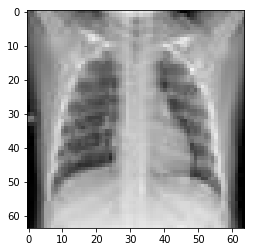

In [7]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]] +  " picture.")

In [8]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 540
Number of testing examples: 60
Each image is of size: (64, 64, 3)
train_x_orig shape: (540, 64, 64, 3)
train_y shape: (1, 540)
test_x_orig shape: (60, 64, 64, 3)
test_y shape: (1, 60)


In [9]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 540)
test_x's shape: (12288, 60)


## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [10]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [ ]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# 600 Elementos
En esta sección se correran diversas pruebas sobre el hiperparametro de learning rate, mientras se mantiene estático el tamaño del dataset en 600 ejemplos

### Learning rate de 0.1

Cost after iteration 0: 0.619365
Cost after iteration 100: 0.602566
Cost after iteration 200: 0.579923
Cost after iteration 300: 0.579915
Cost after iteration 400: 0.579915
Cost after iteration 500: 0.579915
Cost after iteration 600: 0.579915
Cost after iteration 700: 0.579915
Cost after iteration 800: 0.579915
Cost after iteration 900: 0.579915
Cost after iteration 1000: 0.579915
Cost after iteration 1100: 0.579915
Cost after iteration 1200: 0.579915
Cost after iteration 1300: 0.579915
Cost after iteration 1400: 0.579915
Cost after iteration 1500: 0.579915
Cost after iteration 1600: 0.579915
Cost after iteration 1700: 0.579915
Cost after iteration 1800: 0.579915
Cost after iteration 1900: 0.579915
Cost after iteration 2000: 0.579915
Cost after iteration 2100: 0.579915
Cost after iteration 2200: 0.579915
Cost after iteration 2300: 0.579915
Cost after iteration 2400: 0.579915


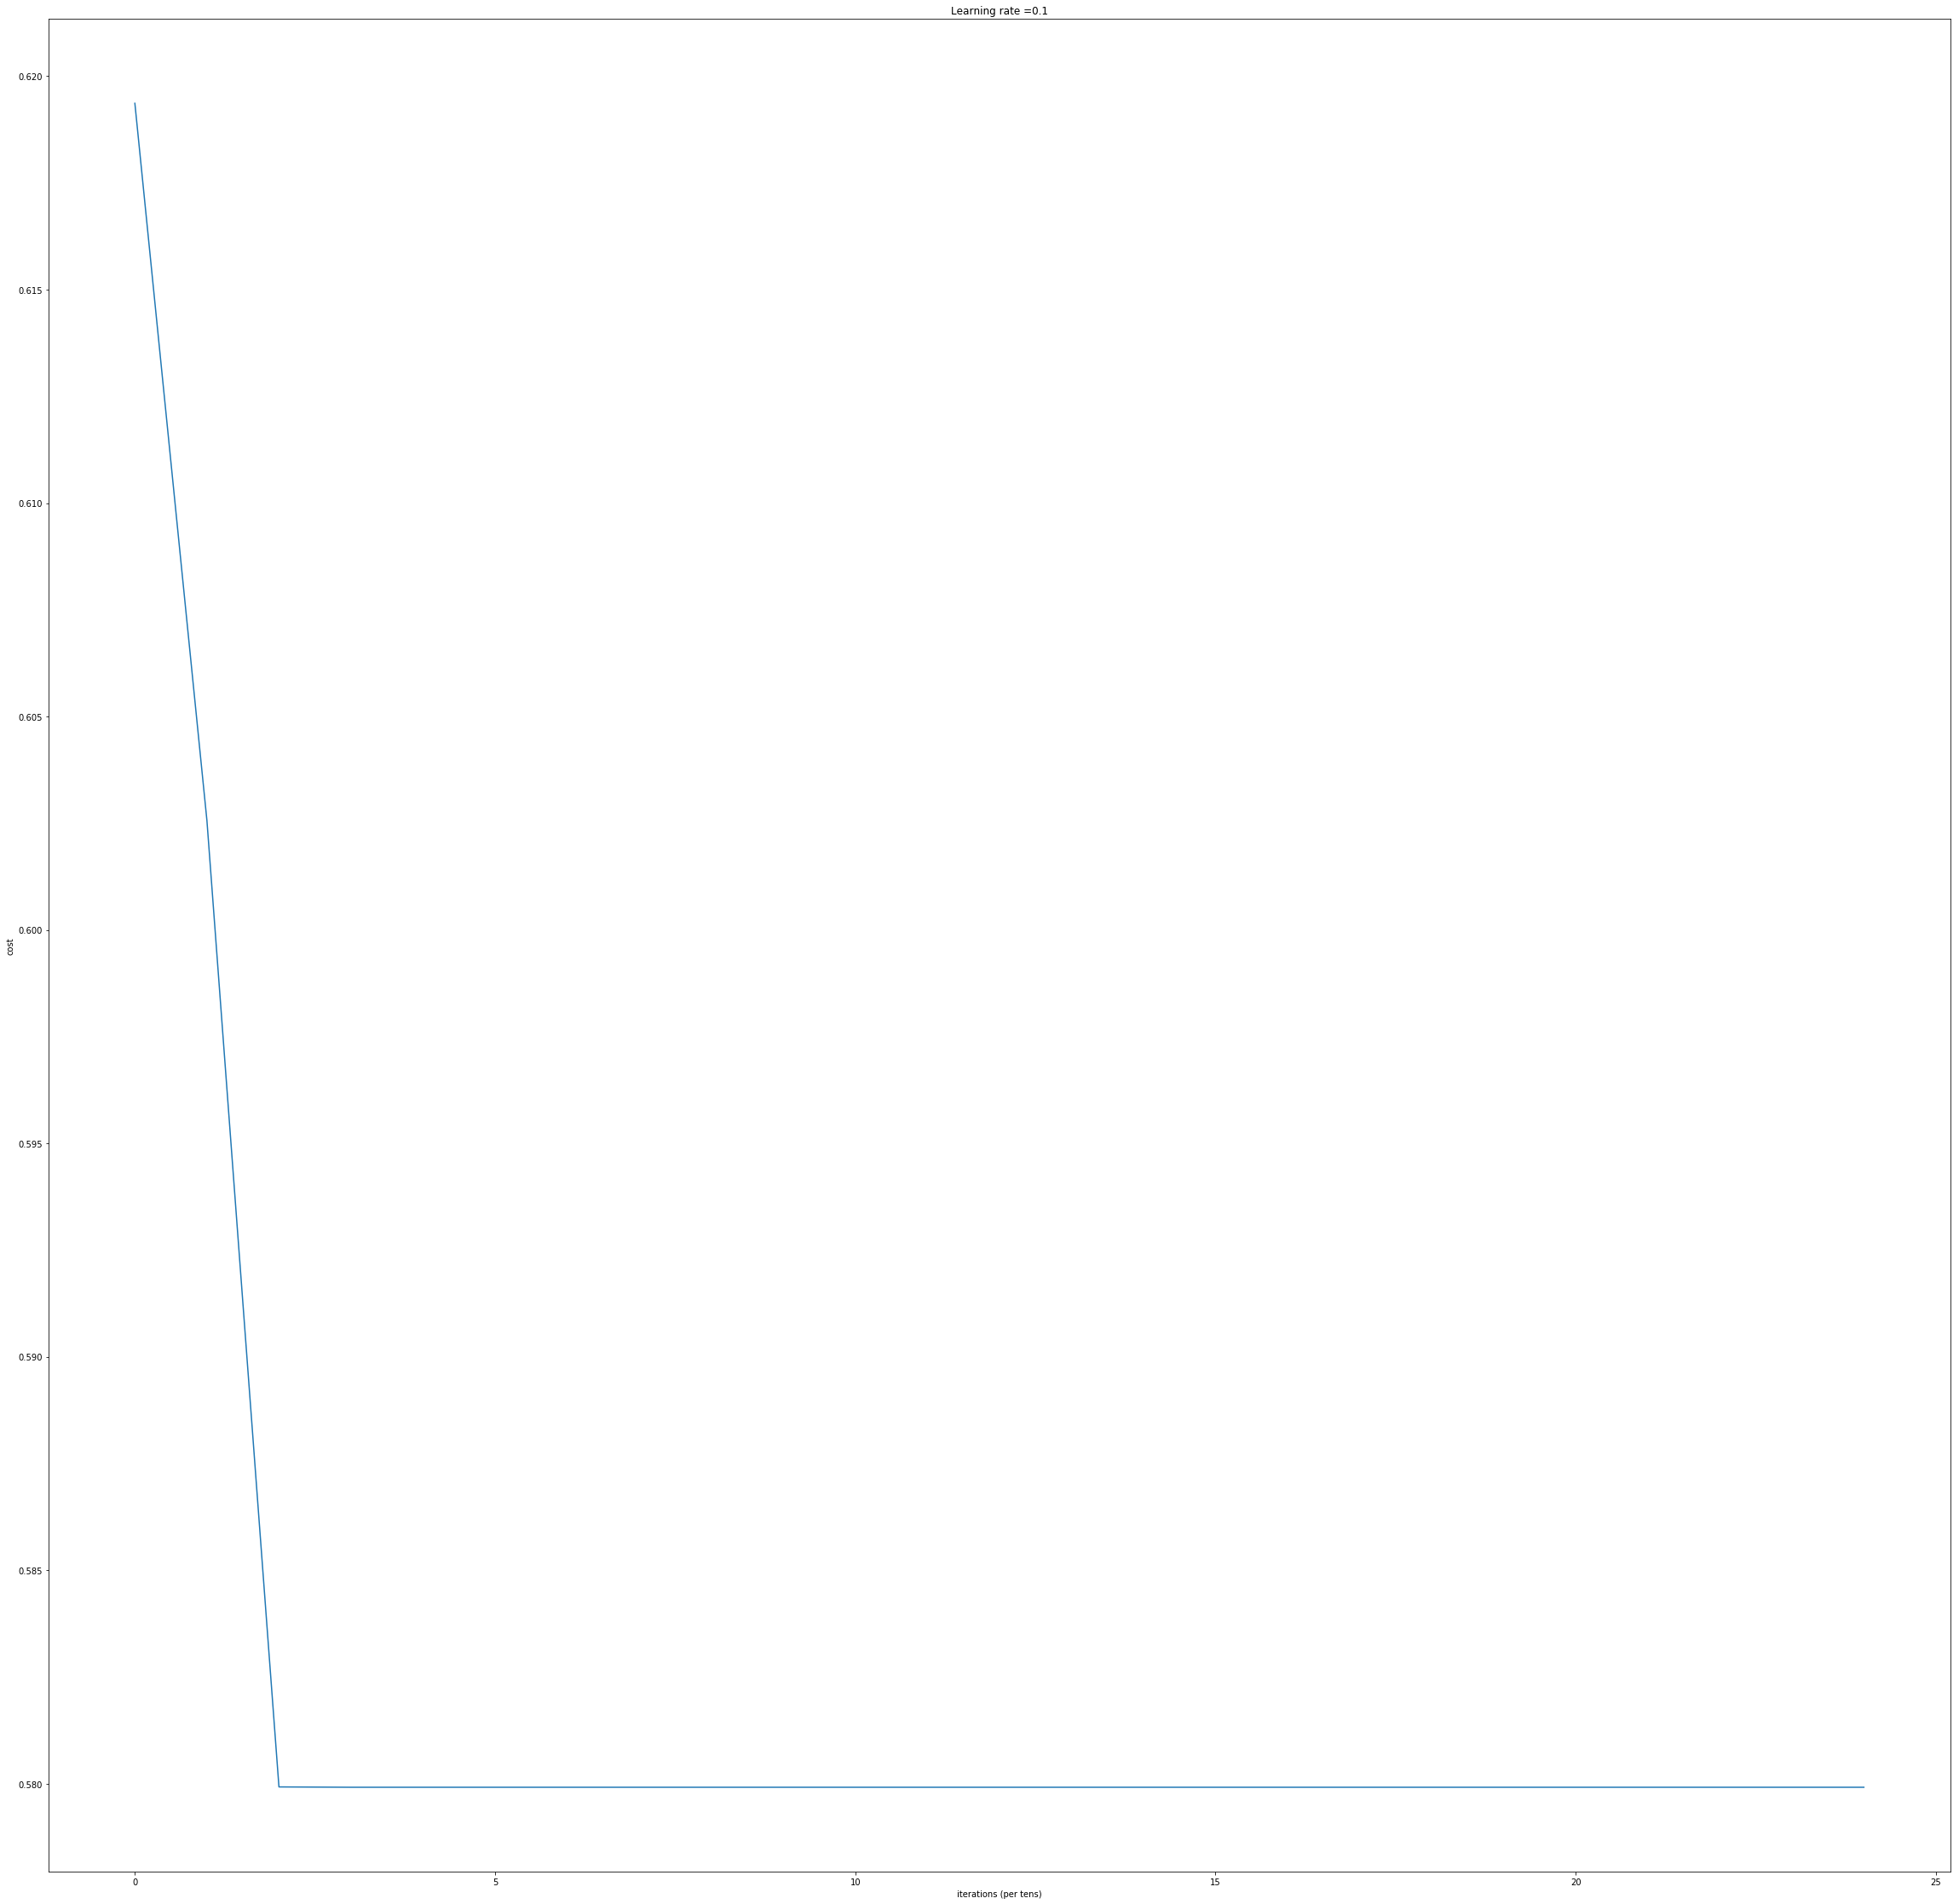

In [22]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.1, num_iterations = 2500, print_cost = True)

In [23]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.7333333333333333


In [24]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.7166666666666668


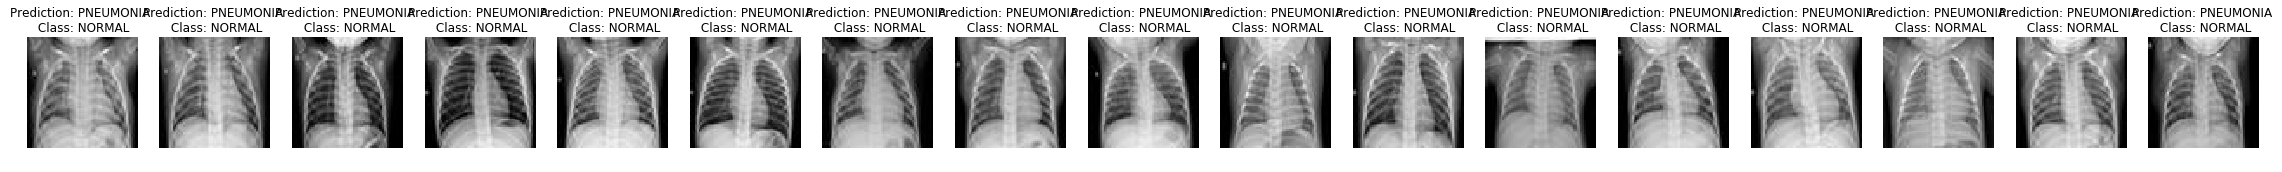

In [25]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

### Learning rate de 0.01

Cost after iteration 0: 0.619365
Cost after iteration 100: 0.439514
Cost after iteration 200: 0.352901
Cost after iteration 300: 0.318275
Cost after iteration 400: 0.308025
Cost after iteration 500: 0.294207
Cost after iteration 600: 0.265003
Cost after iteration 700: 0.267003
Cost after iteration 800: 0.262686
Cost after iteration 900: 0.234521
Cost after iteration 1000: 0.246435
Cost after iteration 1100: 0.199290
Cost after iteration 1200: 0.189113
Cost after iteration 1300: 0.236808
Cost after iteration 1400: 0.198378
Cost after iteration 1500: 0.169291
Cost after iteration 1600: 0.164515
Cost after iteration 1700: 0.160513
Cost after iteration 1800: 0.170791
Cost after iteration 1900: 0.136723
Cost after iteration 2000: 0.134002
Cost after iteration 2100: 0.184028
Cost after iteration 2200: 0.218407
Cost after iteration 2300: 0.119109
Cost after iteration 2400: 0.110945


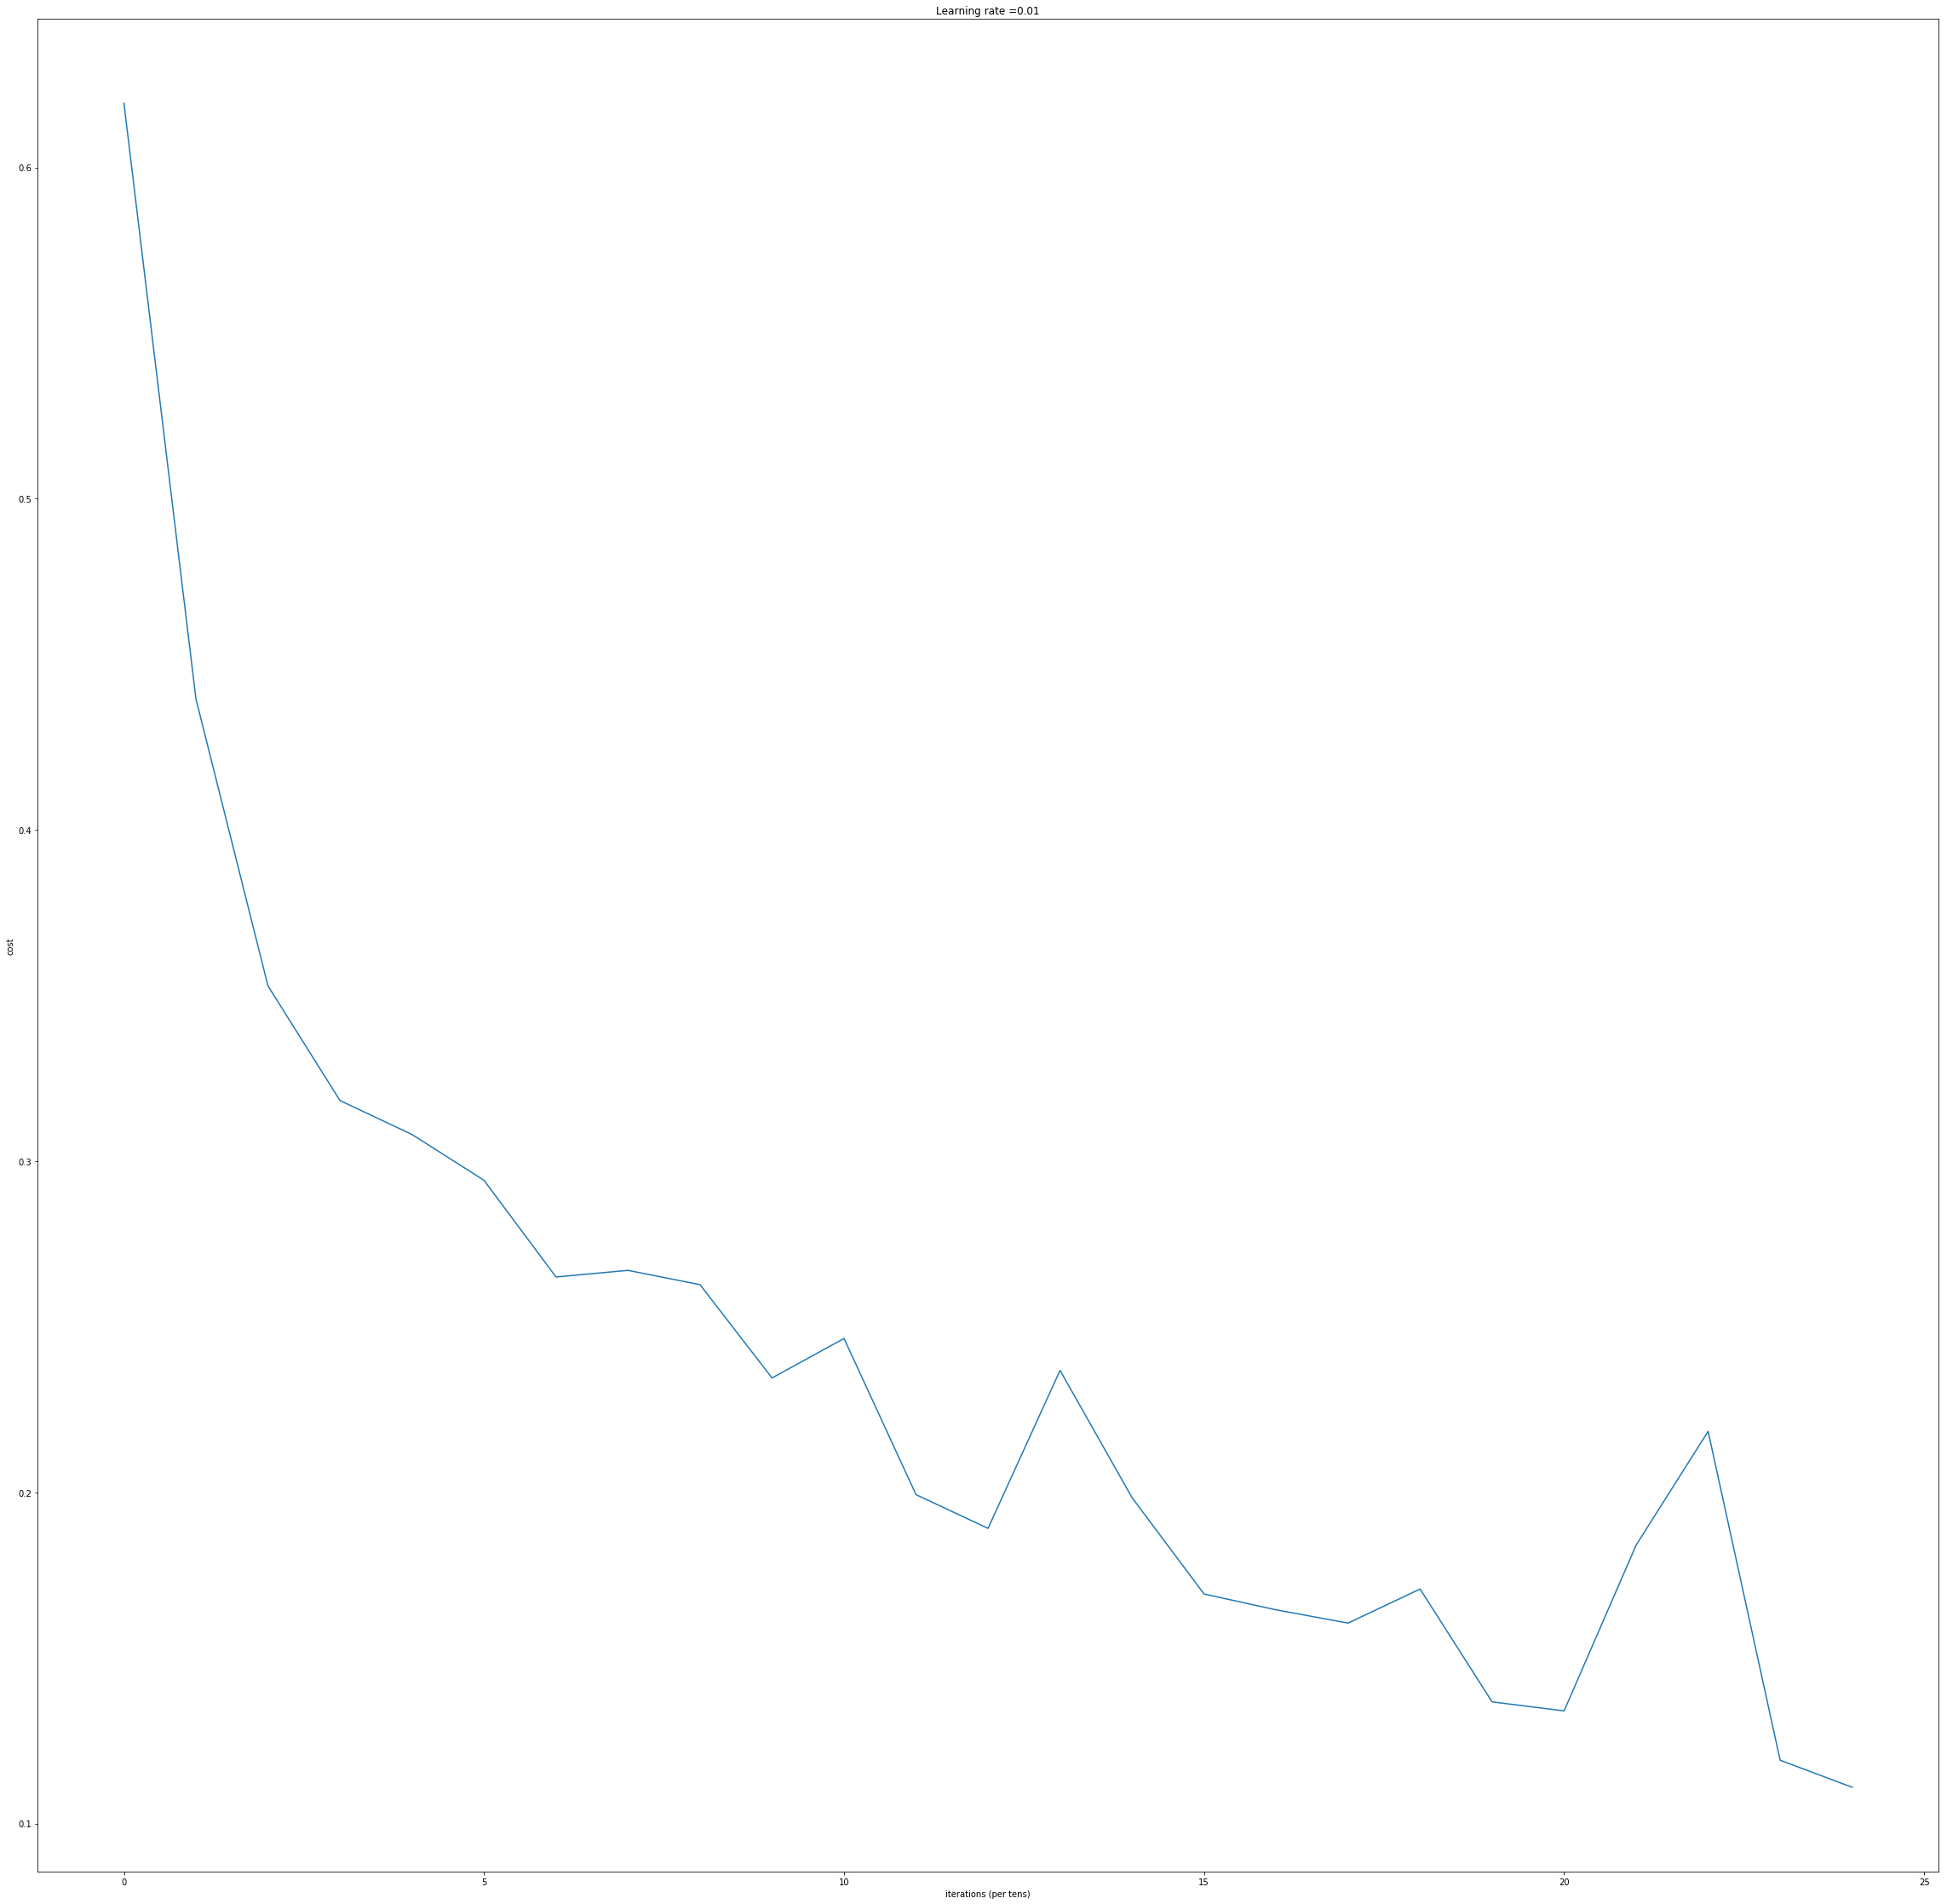

In [26]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.01, num_iterations = 2500, print_cost = True)

In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9814814814814813


In [29]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9500000000000002


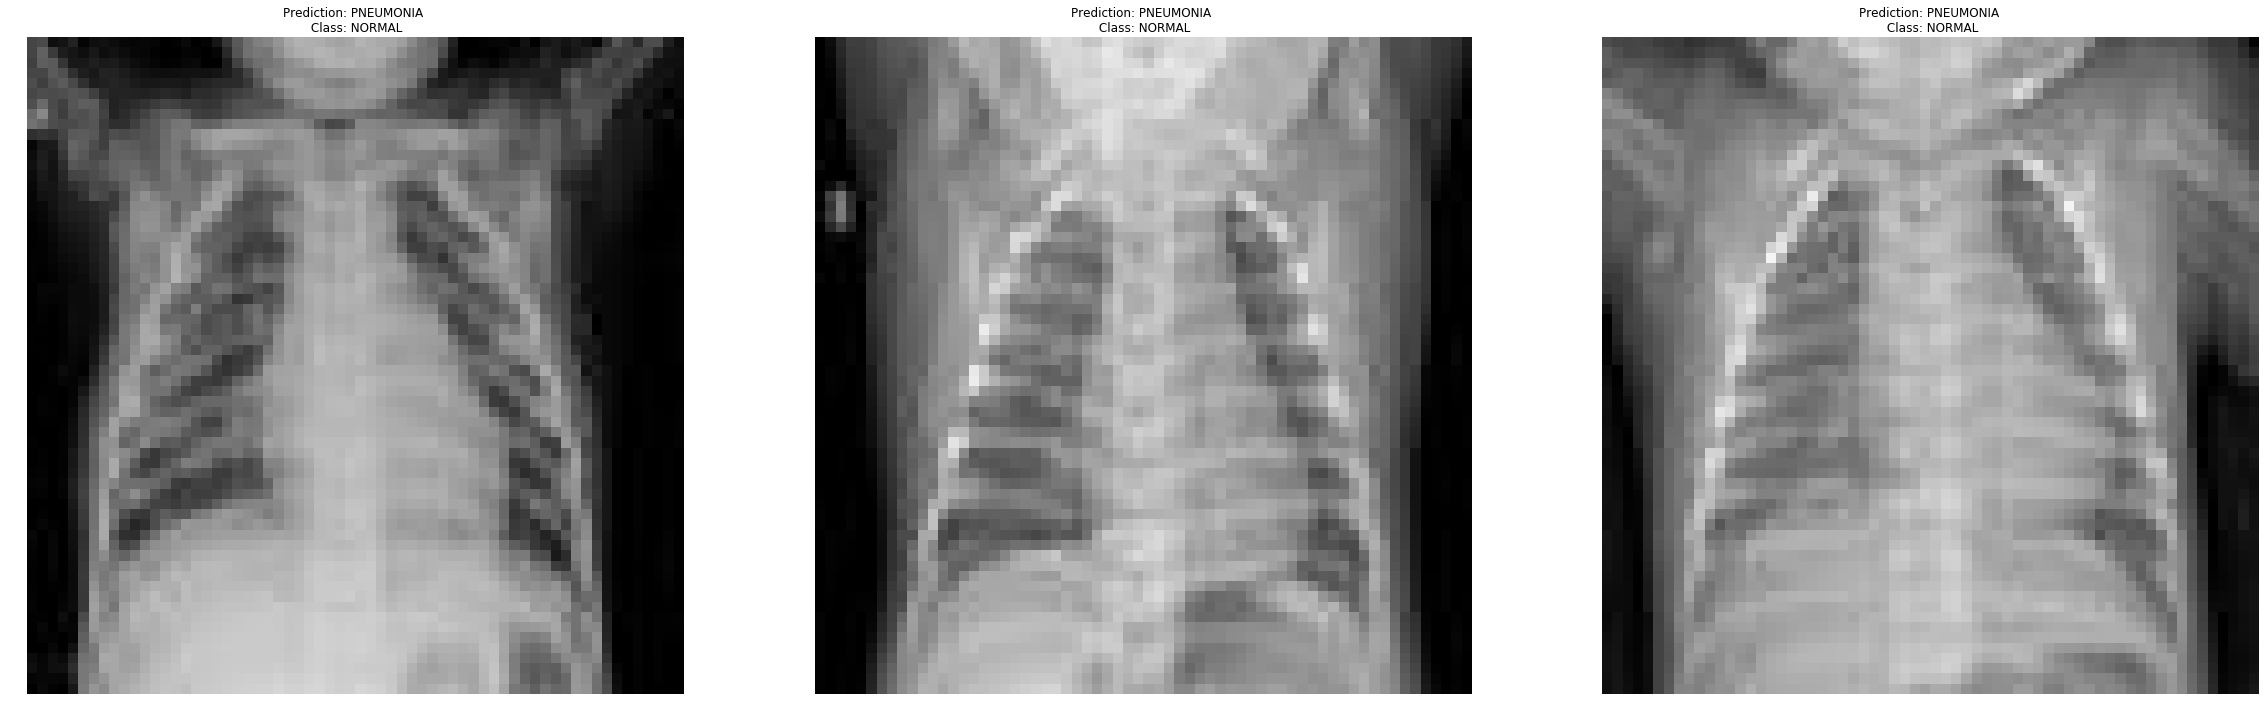

In [30]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

### Learning rate de 0.001

Cost after iteration 0: 0.619365
Cost after iteration 100: 0.510042
Cost after iteration 200: 0.459009
Cost after iteration 300: 0.426922
Cost after iteration 400: 0.404622
Cost after iteration 500: 0.388004
Cost after iteration 600: 0.374773
Cost after iteration 700: 0.363982
Cost after iteration 800: 0.354603
Cost after iteration 900: 0.346580
Cost after iteration 1000: 0.339715
Cost after iteration 1100: 0.333594
Cost after iteration 1200: 0.327919
Cost after iteration 1300: 0.322643
Cost after iteration 1400: 0.317801
Cost after iteration 1500: 0.313293
Cost after iteration 1600: 0.309062
Cost after iteration 1700: 0.305003
Cost after iteration 1800: 0.301071
Cost after iteration 1900: 0.297382
Cost after iteration 2000: 0.293861
Cost after iteration 2100: 0.290536
Cost after iteration 2200: 0.287417
Cost after iteration 2300: 0.284341
Cost after iteration 2400: 0.281338


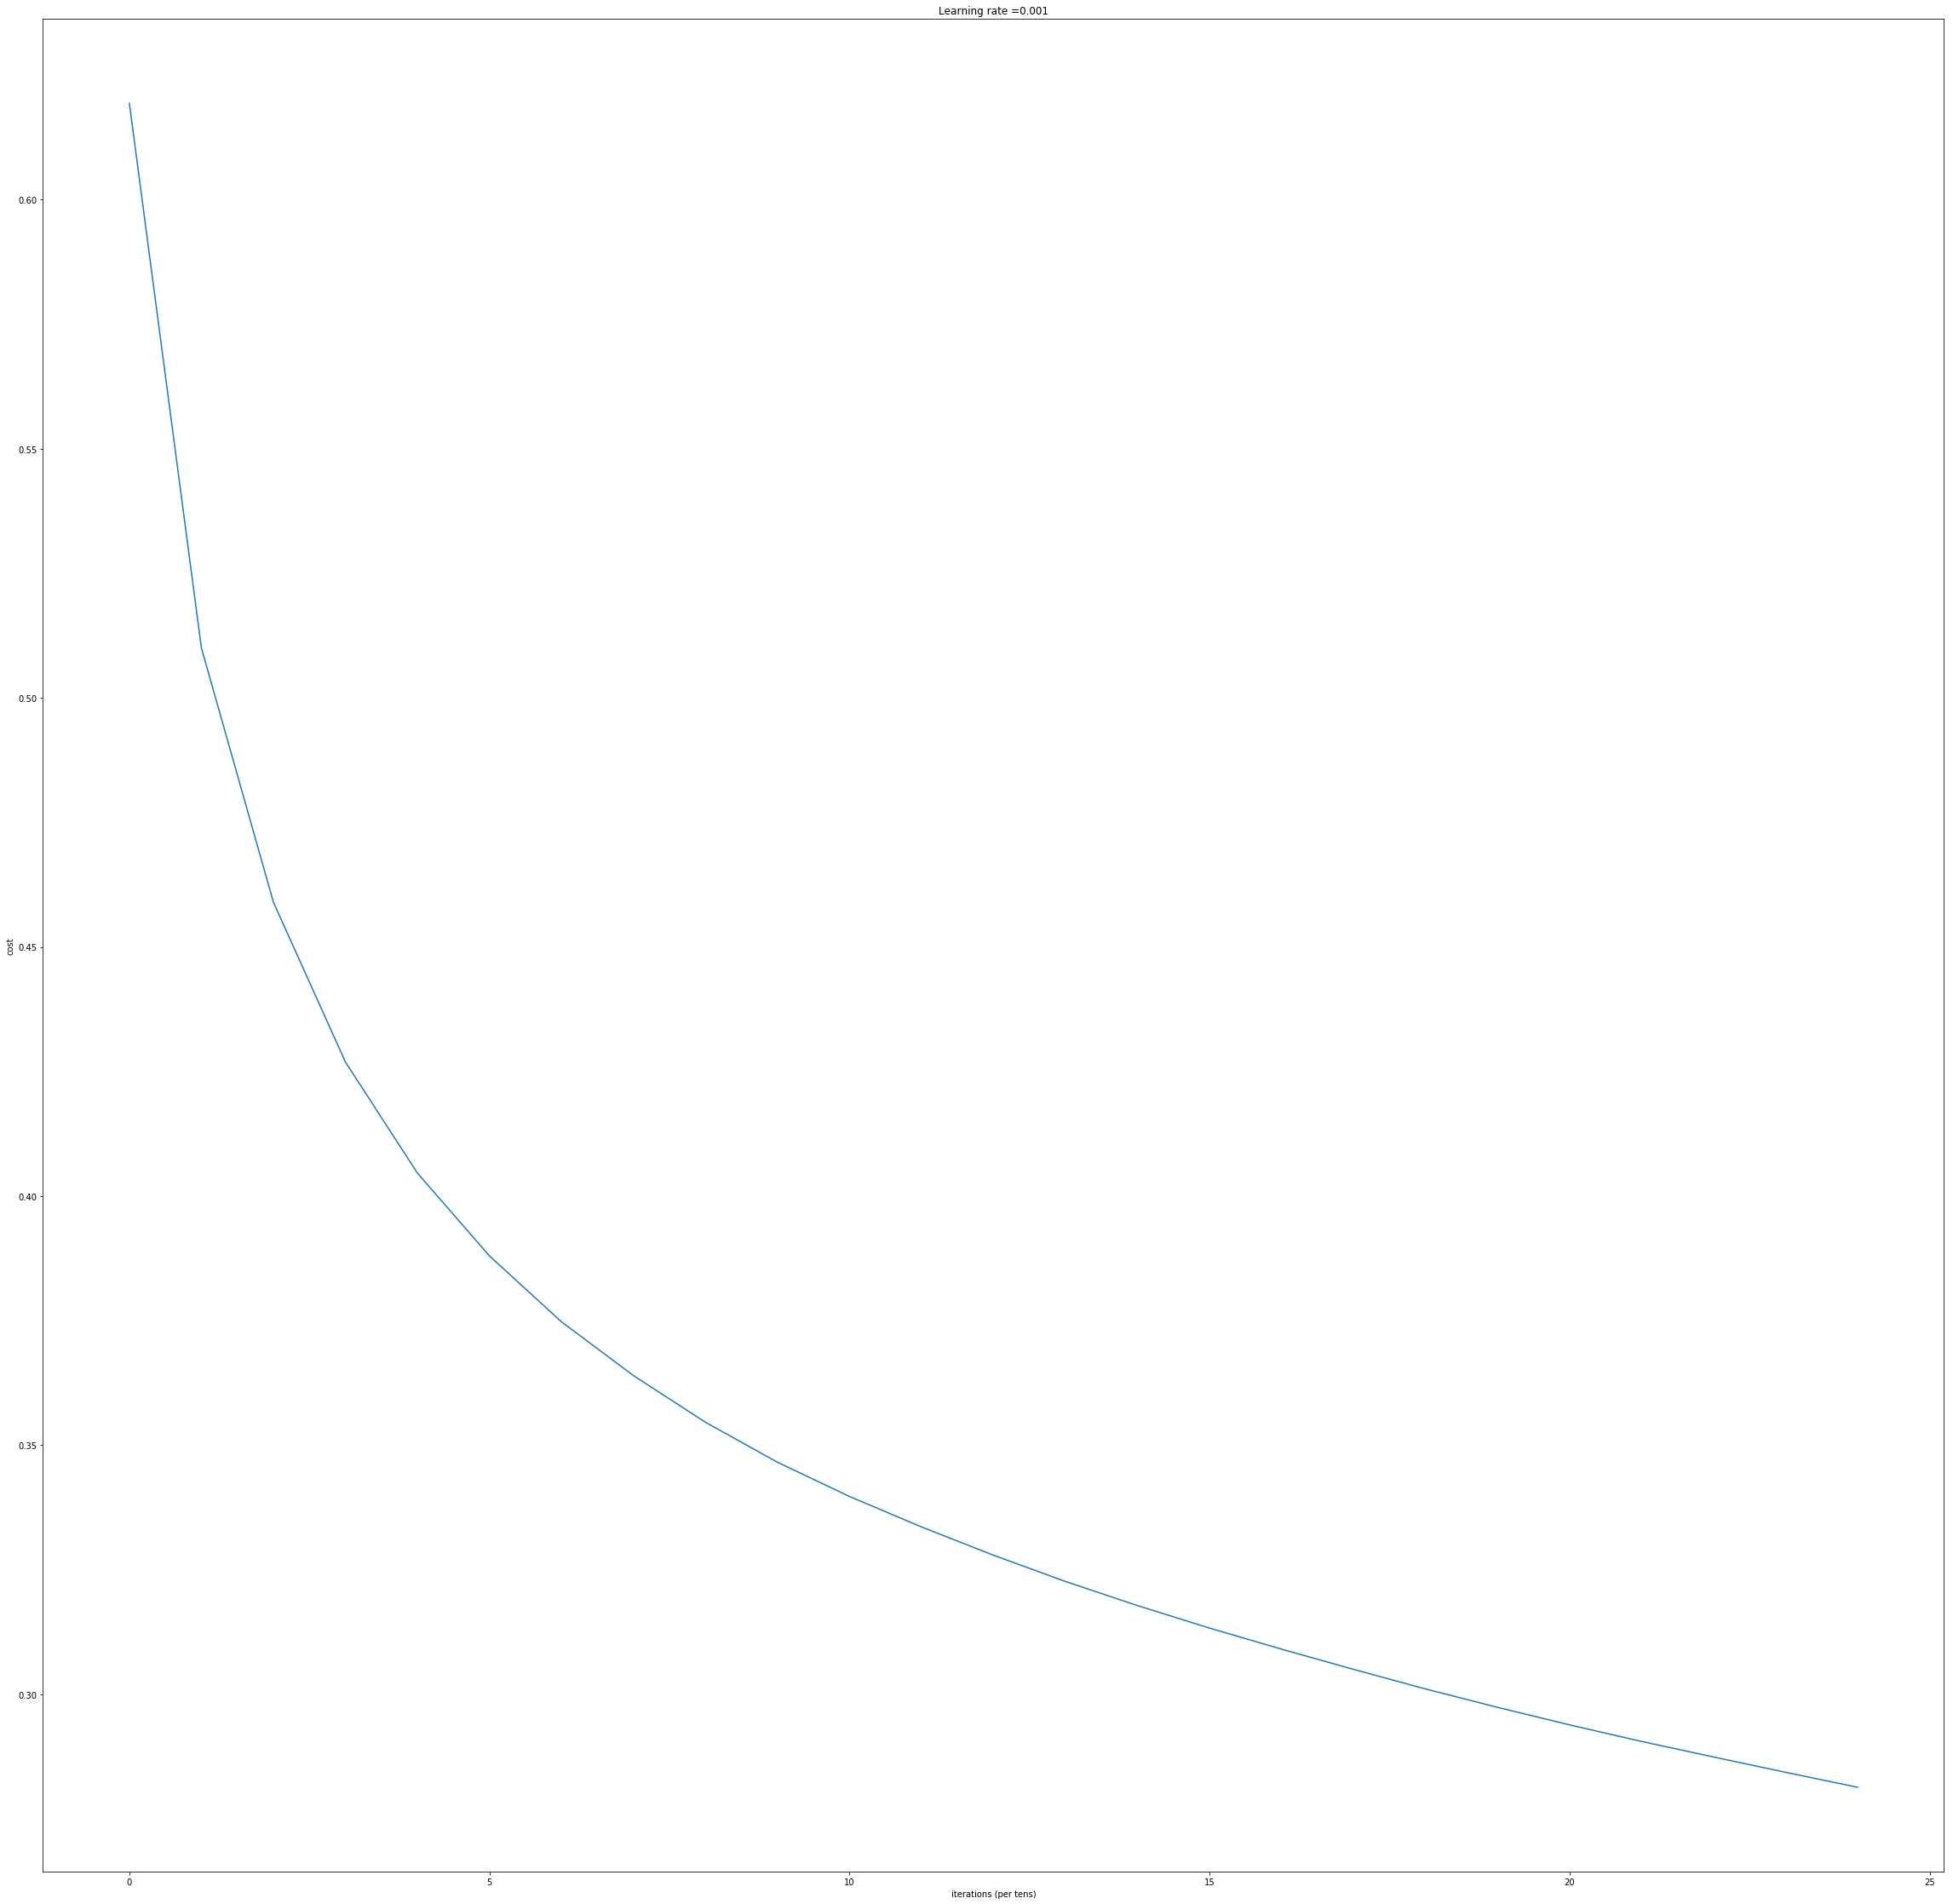

In [31]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.001, num_iterations = 2500, print_cost = True)

In [32]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9277777777777776


In [33]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9000000000000001


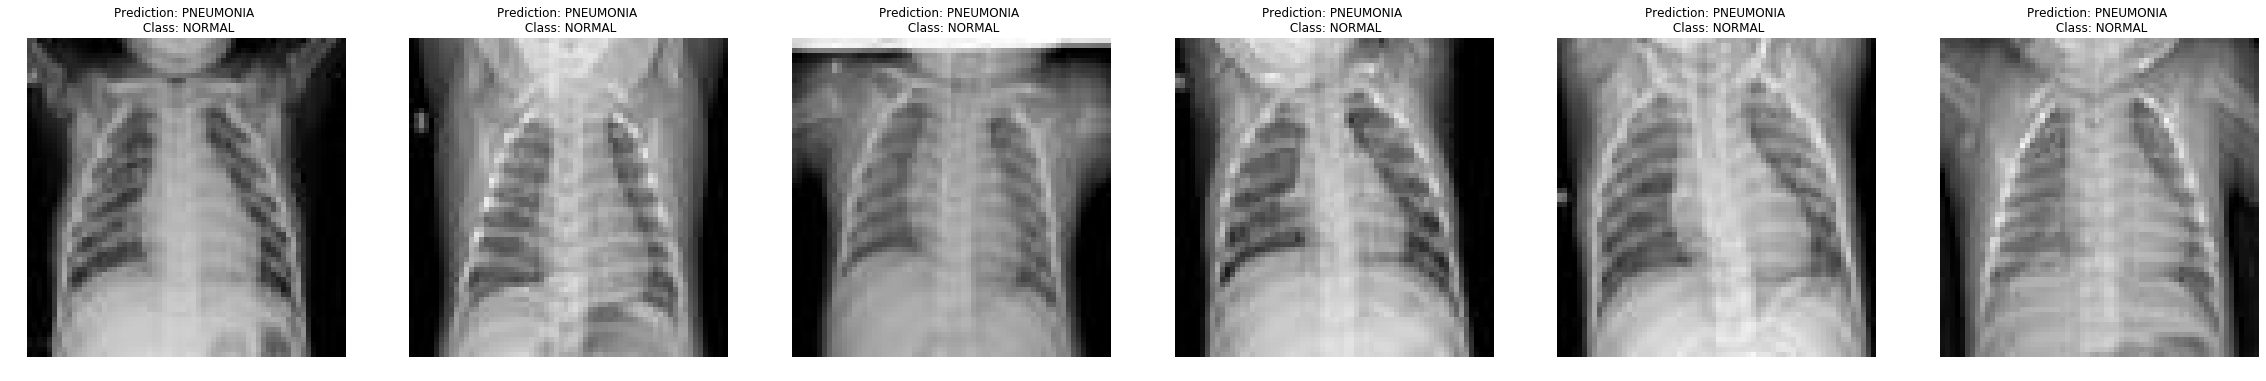

In [34]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

# 1000 elementos
En esta sección se correran diversas pruebas sobre el hiperparametro numero de iteraciones, mientras se mantiene estático el tamaño del dataset en 600 ejemplos

### 500 Iteraciones

In [38]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data(600)

Cost after iteration 0: 0.621032
Cost after iteration 100: 0.585361
Cost after iteration 200: 0.575526
Cost after iteration 300: 0.565614
Cost after iteration 400: 0.564025
Cost after iteration 500: 0.564583
Cost after iteration 600: 0.553996
Cost after iteration 700: 0.547427
Cost after iteration 800: 0.539175
Cost after iteration 900: 0.528872


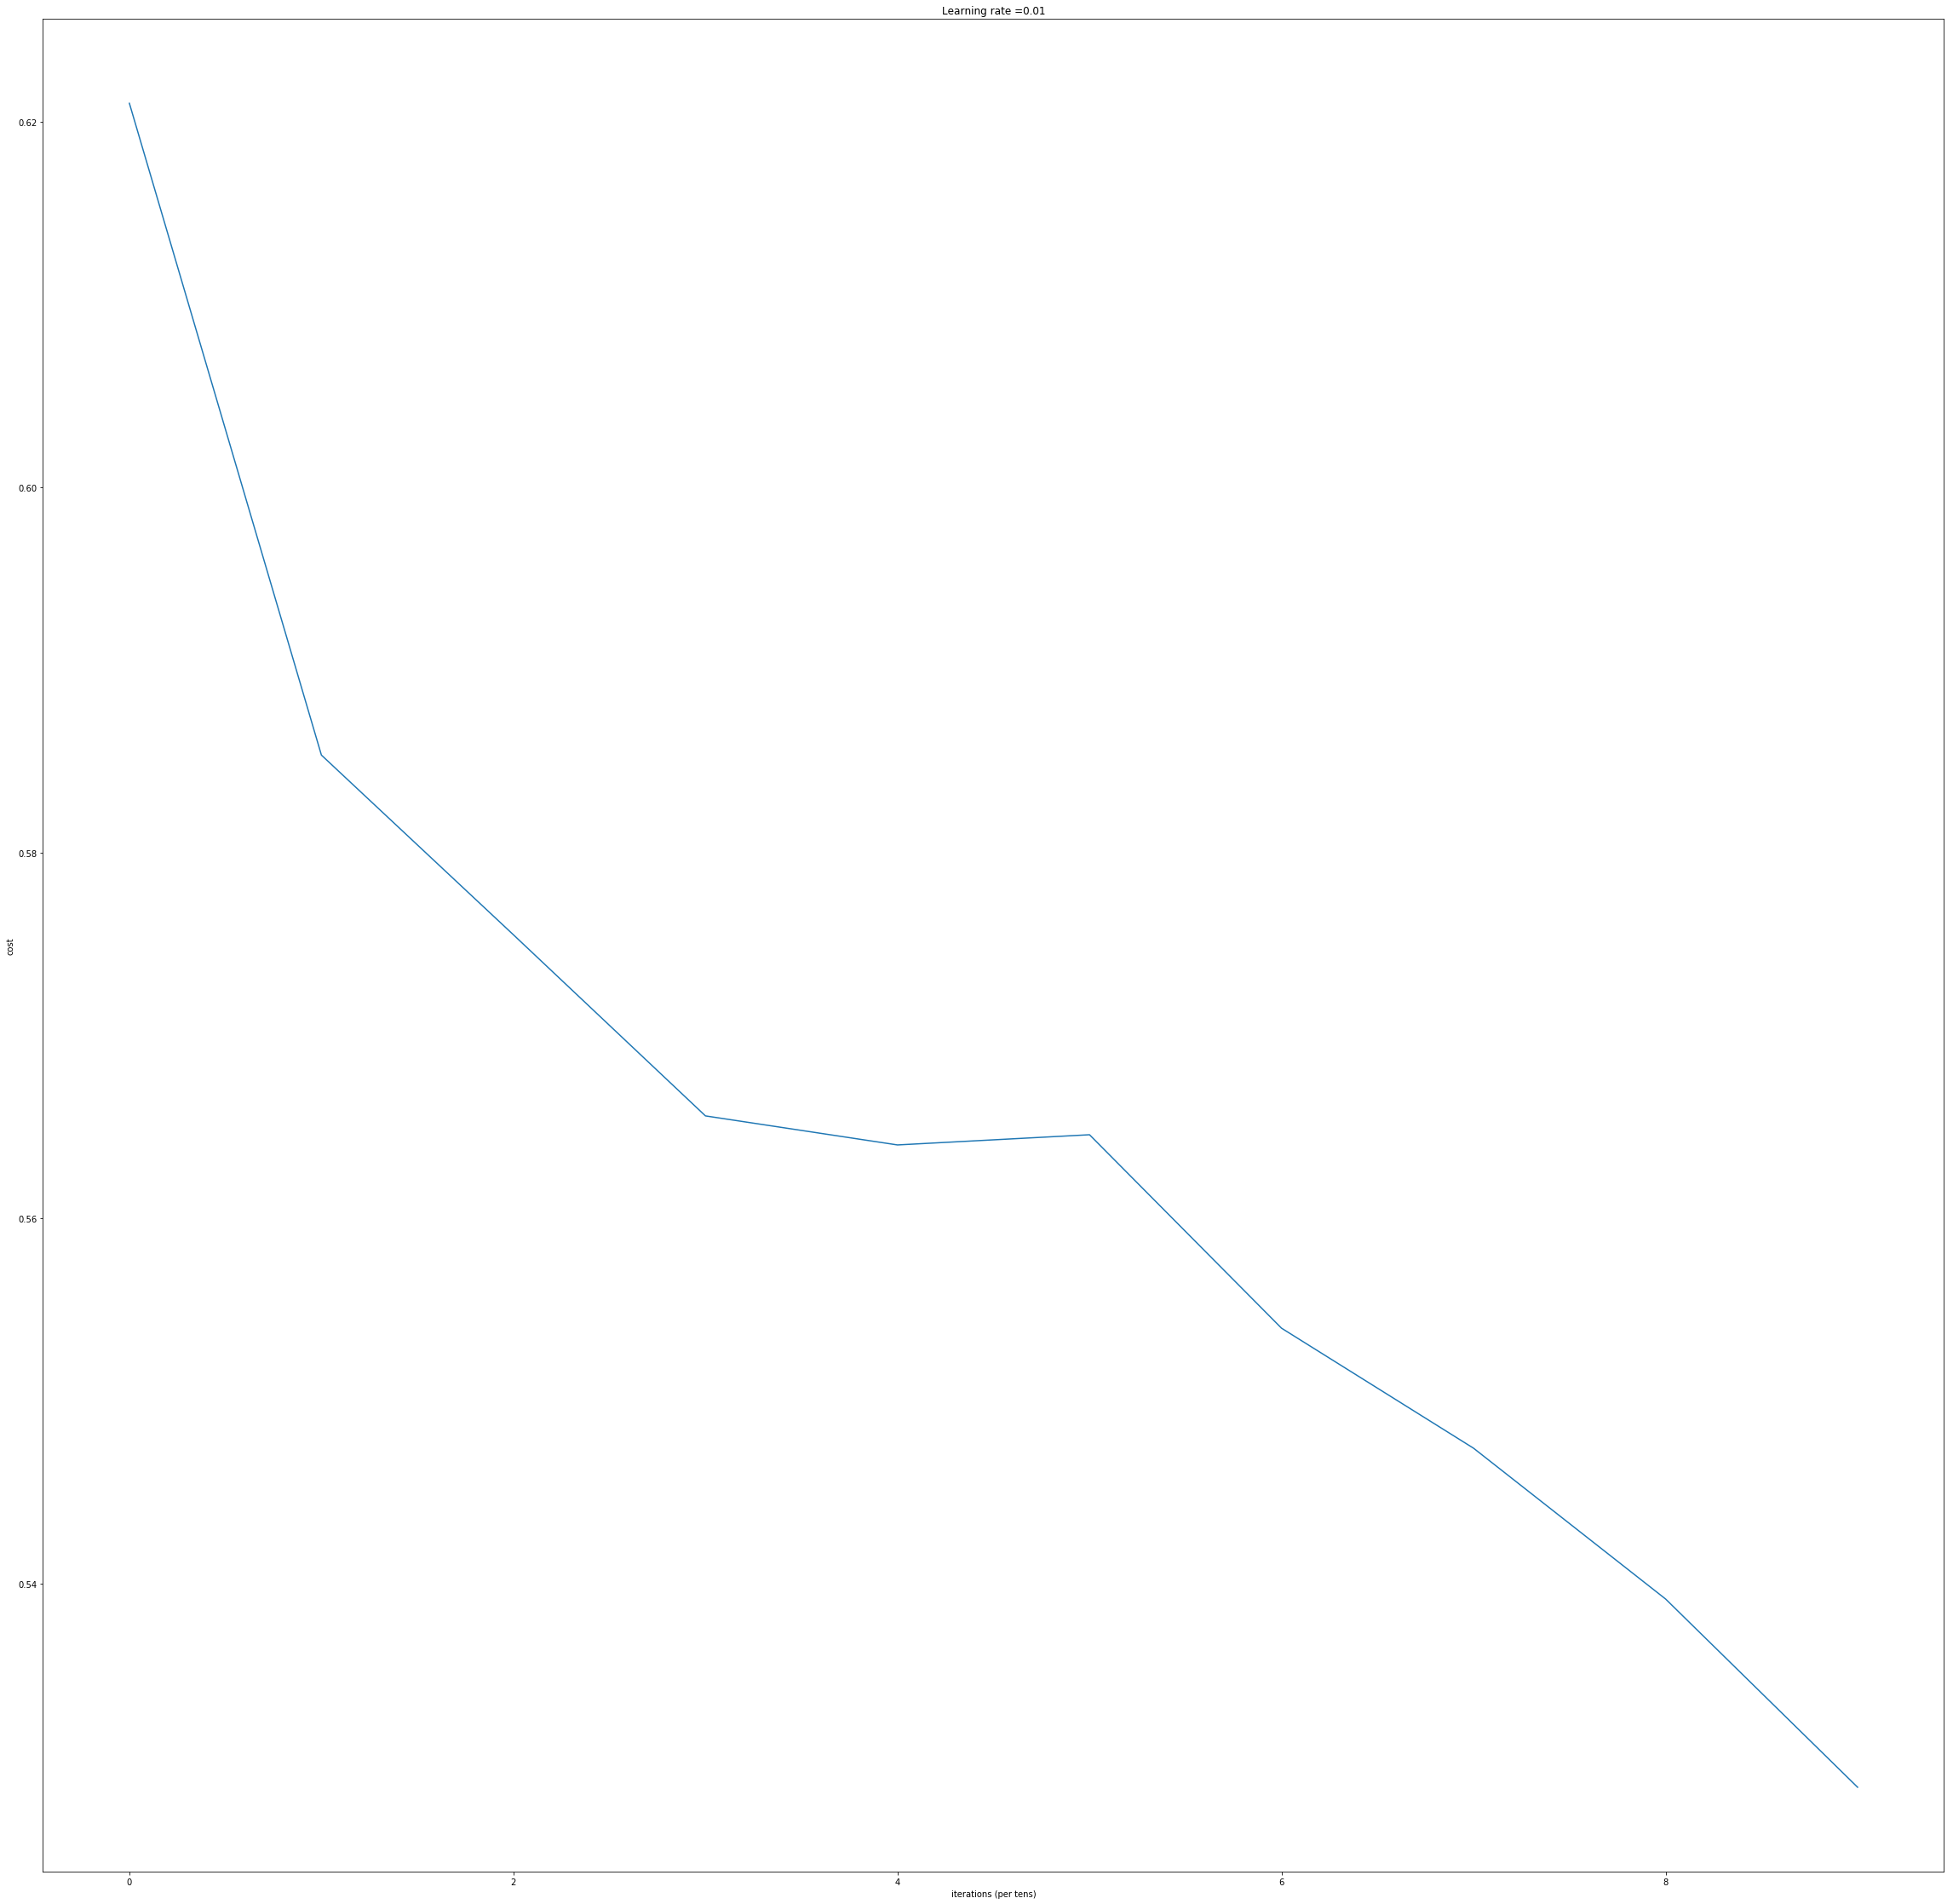

In [40]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate= 0.01, num_iterations = 1000, print_cost = True)